In [1]:
import pandas as pd
import pickle

In [2]:
# Extract ml info
df_extra_features_train_raw = pd.read_csv('../Data/ml_train.csv')
df_extra_features_test_raw = pd.read_csv('../Data/ml_test.csv')

In [3]:
df_extra_features_test_raw = pd.read_csv('../Data/ml_test.csv')# select those columns that Angel used to fit the ML models
selected_columns = ['study_id','site_id','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

df_extra_features_train = df_extra_features_train_raw[selected_columns]
df_extra_features_test = df_extra_features_test_raw[selected_columns]

# Note: it seems that these partitions are different from those used to calibrate DI-ML
# df_train.shape : (790, 25)
# df_test.shape : (217, 25)

df_ML_extra_features_info = pd.concat([df_extra_features_train, df_extra_features_test], ignore_index=True)

In [4]:
df_train_global_regressor = pd.read_csv('../Data/data_train_global_regressor_V0.csv')
df_test_global_regressor = pd.read_csv('../Data/data_test_global_regressor_V0.csv')

In [5]:
df_ML_train = df_train_global_regressor.merge(df_ML_extra_features_info, on=['study_id','site_id'], how='left')
df_ML_test = df_test_global_regressor.merge(df_ML_extra_features_info, on=['study_id','site_id'], how='left')

In [6]:
df_ML_train.to_csv('../Data/df_ML_train_global_regressor_V0.csv', index=False)
df_ML_test.to_csv('../Data/df_ML_test_global_regressor_V0.csv', index=False)

In [7]:
# sanity check
rows_with_na = df_ML_train.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 27 in the training set

# sanity check
rows_with_na = df_ML_test.isna().any(axis=1)
number_rows_with_na = rows_with_na.sum()
print(number_rows_with_na) # 20 in the test set

27
20


In [8]:
# Drop NAs from dataframes
df_ML_train_without_na = df_ML_train.dropna()
df_ML_test_without_na = df_ML_test.dropna()

In [9]:
# Create an iterator for cross validation
df_folds = pd.read_csv('../Data/CV_folds.csv')
df_ML_train_studyid_series = df_ML_train_without_na['study_id']
df_ML_train_studyid = df_ML_train_studyid_series.to_frame(name='study_id')
df_ML_train_folds = df_ML_train_studyid.merge(df_folds, on=['study_id'], how='left')

myCViterator = []
for i in range(0,5):
    trainIndices = df_ML_train_folds[df_ML_train_folds['fold'] != i].index.values.astype(int)
    testIndices = df_ML_train_folds[df_ML_train_folds['fold'] == i].index.values.astype(int)
    myCViterator.append((trainIndices, testIndices))

# Save iterator    
with open('../Data/myCViterator_PREVENT.pkl', 'wb') as f:
    pickle.dump(myCViterator, f)


In [10]:
# Import our cv iterator (K-Folds)
with open('../Data/myCViterator_PREVENT.pkl', 'rb') as file:
        myCViterator = pickle.load(file)

In [11]:
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, uniform
from sklearn.preprocessing import StandardScaler

X_columns_CNN = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
X_columns_NO_CNN = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

y_columns = ['log_vr_total']

X_train_CNN = df_ML_train_without_na[X_columns_CNN]
X_train_NO_CNN = df_ML_train_without_na[X_columns_NO_CNN]
X_test_CNN = df_ML_test_without_na[X_columns_CNN]
X_test_NO_CNN = df_ML_test_without_na[X_columns_NO_CNN]

# Seleccionar las columnas por nombre
columnas_a_escalar_CNN = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']
columnas_a_escalar_NO_CNN = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub']

# Crear una instancia de StandardScaler
scaler_CNN = StandardScaler()
scaler_NO_CNN = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_CNN[columnas_a_escalar_CNN] = scaler_CNN.fit_transform(X_train_CNN[columnas_a_escalar_CNN])
X_train_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.fit_transform(X_train_NO_CNN[columnas_a_escalar_NO_CNN])

# Aplicar la transformación a los datos de prueba usando los valores ajustados de los datos de entrenamiento
X_test_CNN[columnas_a_escalar_CNN] = scaler_CNN.transform(X_test_CNN[columnas_a_escalar_CNN])
X_test_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.transform(X_test_NO_CNN[columnas_a_escalar_NO_CNN])

y_train = df_ML_train_without_na[y_columns]
y_test = df_ML_test_without_na[y_columns]

C:\Users\alfon\AppData\Local\Temp\ipykernel_27484\2044280784.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_CNN[columnas_a_escalar_CNN] = scaler_CNN.fit_transform(X_train_CNN[columnas_a_escalar_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_27484\2044280784.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_NO_CNN[columnas_a_escalar_NO_CNN] = scaler_NO_CNN.fit_transform(X_train_NO_CNN[columnas_a_escalar_NO_CNN])
C:\Users\alfon\AppData\Local\Temp\ipykernel_27484\2044280784.py:32: S

In [12]:
# Model definition
model_bayesian_ridge = BayesianRidge(n_iter=25000)

# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'alpha_1': uniform(loc=0, scale=1),
    'alpha_2': uniform(loc=0, scale=1),
    'lambda_1': uniform(loc=0, scale=1),
    'lambda_2': uniform(loc=0, scale=1),
    'fit_intercept': [False, True]
}

# Cross validation strategy (here we use K-Fold)
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

# Random search of best hyperparameter combinations
grid_search = RandomizedSearchCV(model_bayesian_ridge, param_distributions = param_grid, cv = myCViterator,
                            scoring = 'neg_mean_absolute_error', n_iter = 10000,
                            verbose = 2, random_state = 135, n_jobs = 8)

grid_search.fit(X_train_CNN, y_train)

# best hyperparameter combination
best_hyperparameters_CNN = grid_search.best_params_

# best model
best_model_CNN = grid_search.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
best_model_CNN

BayesianRidge(alpha_1=0.2226205582312254, alpha_2=0.8878763707771585,
              lambda_1=0.9027741603701731, lambda_2=0.0019529592485052483,
              n_iter=25000)

In [14]:
# make predictions
y_pred_CNN = best_model_CNN.predict(X_test_CNN)

# Evaluation of our best model
mae = mean_absolute_error(y_test, y_pred_CNN)
mse = mean_squared_error(y_test, y_pred_CNN)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_CNN)

# Estimate spearman rho
coef_spearman, p_valor_spearman = spearmanr(y_test, y_pred_CNN)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse)
print("Root mean square error (RMSE):", rmse)
print("Mean absolute error (MAE):", mae)
print("R-squared:", r2)
print("Spearman-rho:", coef_spearman,"(pvalor:",p_valor_spearman,")")


Mean square error (MSE): 1.6853400588201395
Root mean square error (RMSE): 1.2982064777300024
Mean absolute error (MAE): 1.052785577412645
R-squared: 0.17676727795535352
Spearman-rho: 0.4843584448928614 (pvalor: 3.3848375282699367e-10 )


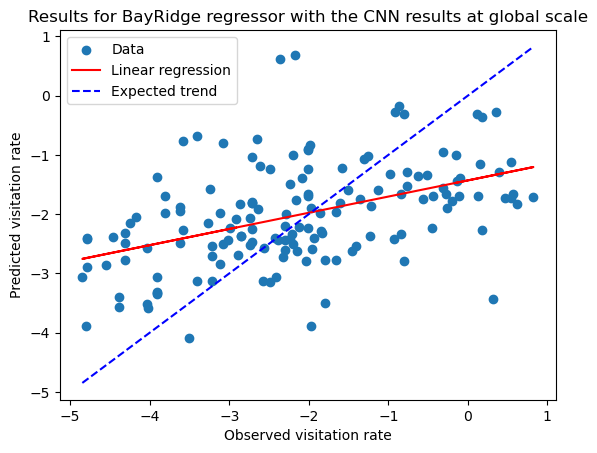

In [15]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_CNN, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_CNN, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for BayRidge regressor with the CNN results at global scale')

# show legend
plt.legend()

# show plot
plt.show()

global_regressor_V0: VIP = 21.677679132463656
bio08: VIP = 4.229522217819491
bio01: VIP = 4.0698795908826115
elevation: VIP = 3.8377795127501773
x0_5.0: VIP = 3.8299796351643702
management_y: VIP = 3.088032657434793
bio14: VIP = 2.98834307149002
x0_1.0: VIP = 2.810110524727909
x0_10.0: VIP = 2.544886286808317
moss: VIP = 2.474583734096944
x0_2.0: VIP = 2.431750943224291
soil_den_b10: VIP = 1.6384393829844042
bio02: VIP = 1.3644281413919321
ec: VIP = 1.2487112629394068
pdsi: VIP = 1.1582171488193114
es: VIP = 0.9034629766978131
gHM: VIP = 0.9004103407425345
shrub: VIP = 0.8079097609151931
x0_4.0: VIP = 0.7849206957094972
x0_12.0: VIP = 0.6661114707041579
x0_7.0: VIP = 0.5520386169070413
bio05: VIP = 0.3486563157030191
x0_8.0: VIP = 0.2358859249400958


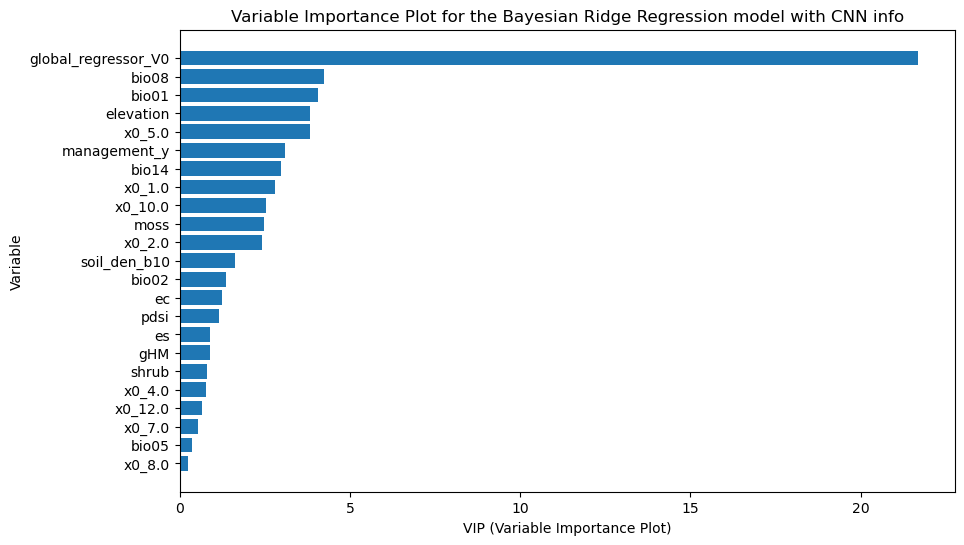

In [16]:
# Get coef. from the best model estimated
coeficients = best_model_CNN.coef_

# Get variance from the estimated coeficients
variance_coefs = np.var(coeficients)

# Estimate VIP for each variable
VIP = np.abs(coeficients) / variance_coefs

# Sort VIP
sorted_indices = np.argsort(VIP)[::-1]  # Sort from larger to smaller VIP
sorted_VIP = VIP[sorted_indices]

# Print VIP
for i, idx in enumerate(sorted_indices):
    print(f"{X_columns_CNN[idx]}: VIP = {sorted_VIP[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), sorted_VIP, align='center')
plt.yticks(range(len(sorted_indices)), [X_columns_CNN[i] for i in sorted_indices])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Bayesian Ridge Regression model with CNN info')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

In [ ]:
# y usando grandient boost??

In [ ]:
# Y si eliminamos varibales altamente correlacionadas antes de ajustar el modelo?

In [17]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df, columns):
    vif_data = pd.DataFrame()
    vif_data["feature"] = columns
    vif_data["VIF"] = [variance_inflation_factor(df[columns].values, i) for i in range(len(columns))]
    return vif_data

X_columns_CNN_raw = ['global_regressor_V0','bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']
X_columns_NO_CNN_raw = ['bio01','bio02','bio05','bio08','bio14','ec','elevation','es','gHM','pdsi','soil_den_b10','moss','shrub','management_y','x0_1.0','x0_2.0','x0_4.0','x0_5.0','x0_7.0','x0_8.0','x0_10.0','x0_12.0']

y_columns = ['log_vr_total']

X_train_CNN_raw = df_ML_train_without_na[X_columns_CNN_raw]
X_train_NO_CNN_raw = df_ML_train_without_na[X_columns_NO_CNN_raw]
X_test_CNN_raw = df_ML_test_without_na[X_columns_CNN_raw]
X_test_NO_CNN_raw = df_ML_test_without_na[X_columns_NO_CNN_raw]


# Calcular VIF para X_train_CNN
vif_CNN = calculate_vif(X_train_CNN_raw, X_columns_CNN_raw)
print("VIF para X_train_CNN:")
print(vif_CNN)

# Calcular VIF para X_train_NO_CNN
vif_NO_CNN = calculate_vif(X_train_NO_CNN_raw, X_columns_NO_CNN_raw)
print("VIF para X_train_NO_CNN:")
print(vif_NO_CNN)

VIF para X_train_CNN:
                feature        VIF
0   global_regressor_V0   1.804361
1                 bio01  13.336954
2                 bio02   6.033153
3                 bio05  12.324574
4                 bio08   3.457263
5                 bio14   2.121200
6                    ec   7.421942
7             elevation   6.482249
8                    es   3.007624
9                   gHM   2.863368
10                 pdsi   1.968357
11         soil_den_b10   3.178869
12                 moss   1.405711
13                shrub   3.457373
14         management_y   1.605233
15               x0_1.0  12.552840
16               x0_2.0   2.498524
17               x0_4.0   9.820419
18               x0_5.0   3.339167
19               x0_7.0   3.314832
20               x0_8.0   2.931238
21              x0_10.0   2.473111
22              x0_12.0   3.278426
VIF para X_train_NO_CNN:
         feature        VIF
0          bio01  13.126806
1          bio02   5.688380
2          bio05  12.310339
3

In [18]:
# Definir un umbral para VIF
vif_threshold = 8

# Filtrar las columnas que tienen VIF menor que el umbral
selected_columns_CNN_raw = vif_CNN[vif_CNN["VIF"] < vif_threshold]["feature"].tolist()
selected_columns_NO_CNN_raw = vif_NO_CNN[vif_NO_CNN["VIF"] < vif_threshold]["feature"].tolist()

# Crear nuevos DataFrames con las columnas seleccionadas
X_train_CNN_raw_reduced = X_train_CNN_raw[selected_columns_CNN_raw]
X_train_NO_CNN_raw_reduced = X_train_NO_CNN_raw[selected_columns_NO_CNN_raw]
X_test_CNN_raw_reduced = X_test_CNN_raw[selected_columns_CNN_raw]
X_test_NO_CNN_raw_reduced = X_test_NO_CNN_raw[selected_columns_NO_CNN_raw]

print("Columnas seleccionadas para X_train_CNN:", selected_columns_CNN_raw)
print("Columnas seleccionadas para X_train_NO_CNN:", selected_columns_NO_CNN_raw)

Columnas seleccionadas para X_train_CNN: ['global_regressor_V0', 'bio02', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_2.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']
Columnas seleccionadas para X_train_NO_CNN: ['bio02', 'bio08', 'bio14', 'ec', 'elevation', 'es', 'gHM', 'pdsi', 'soil_den_b10', 'moss', 'shrub', 'management_y', 'x0_2.0', 'x0_4.0', 'x0_5.0', 'x0_7.0', 'x0_8.0', 'x0_10.0', 'x0_12.0']


In [19]:
# Crear una instancia de StandardScaler
scaler_CNN_raw = StandardScaler()
scaler_NO_CNN_raw = StandardScaler()

# Ajustar el scaler solo con los datos de entrenamiento y luego transformar los datos de entrenamiento
X_train_CNN_raw_reduced_sc = scaler_CNN_raw.fit_transform(X_train_CNN_raw_reduced)
X_train_NO_CNN_raw_reduced_sc = scaler_NO_CNN_raw.fit_transform(X_train_NO_CNN_raw_reduced)

In [21]:
grid_search.fit(X_train_CNN_raw_reduced_sc, y_train)

# best hyperparameter combination
best_hyperparameters_CNN = grid_search.best_params_

# best model
best_model_CNN_reduced = grid_search.best_estimator_

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
# make predictions
y_pred_CNN_raw_reduced = best_model_CNN_reduced.predict(X_test_CNN_raw_reduced)

# Evaluation of our best model
mae_raw_reduced = mean_absolute_error(y_test, y_pred_CNN_raw_reduced)
mse_raw_reduced = mean_squared_error(y_test, y_pred_CNN_raw_reduced)
rmse_raw_reduced = np.sqrt(mse_raw_reduced)
r2_raw_reduced = r2_score(y_test, y_pred_CNN_raw_reduced)

# Estimate spearman rho
coef_spearman_raw_reduced, p_valor_spearman_raw_reduced = spearmanr(y_test, y_pred_CNN_raw_reduced)

# Best model results
# print("Model coefficients:", best_model_CNN.coef_)
# print("Intercept:", best_model_CNN.intercept_)
print("Mean square error (MSE):", mse_raw_reduced)
print("Root mean square error (RMSE):", rmse_raw_reduced)
print("Mean absolute error (MAE):", mae_raw_reduced)
print("R-squared:", r2_raw_reduced)
print("Spearman-rho:", coef_spearman_raw_reduced,"(pvalor:",p_valor_spearman_raw_reduced,")")

Mean square error (MSE): 4.960576639352256
Root mean square error (RMSE): 2.2272352007258363
Mean absolute error (MAE): 1.8923804366802233
R-squared: -1.4230771637766302
Spearman-rho: 0.47574376378648864 (pvalor: 7.626853682587354e-10 )


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but BayesianRidge was fitted without feature names
  warnings.warn(


In [ ]:
# Está metiendo ruido la prediccion de las CNNs??? Posiblemente sí

In [23]:
# Fit model without CNN info (global regressor)
grid_search.fit(X_train_NO_CNN, y_train)

# best hyperparameter combination
best_hyperparameters_NO_CNN = grid_search.best_params_

# best model
best_model_NO_CNN = grid_search.best_estimator_


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\linear_model\_bayes.py:53: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.3 and will be removed in 1.5
  warnings.warn(
C:\Users\alfon\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [24]:
best_model_NO_CNN

BayesianRidge(alpha_1=0.2226205582312254, alpha_2=0.8878763707771585,
              lambda_1=0.9027741603701731, lambda_2=0.0019529592485052483,
              n_iter=25000)

In [25]:
# make predictions
y_pred_NO_CNN = best_model_NO_CNN.predict(X_test_NO_CNN)

# Evaluation of our best model
mae_NO_CNN = mean_absolute_error(y_test, y_pred_NO_CNN)
mse_NO_CNN = mean_squared_error(y_test, y_pred_NO_CNN)
rmse_NO_CNN = np.sqrt(mse_NO_CNN)
r2_NO_CNN = r2_score(y_test, y_pred_NO_CNN)

# Estimate spearman rho
coef_spearman_NO_CNN, p_valor_spearman_NO_CNN = spearmanr(y_test, y_pred_NO_CNN)

# Best model results
# print("Model coefficients:", best_model_NO_CNN.coef_)
# print("Intercept:", best_model_NO_CNN.intercept_)
print("Mean square error (MSE):", mse_NO_CNN)
print("Root mean square error (RMSE):", rmse_NO_CNN)
print("R-squared:", r2_NO_CNN)
print("Mean absolute error (MAE):", mae_NO_CNN)
print("Spearman-rho:", coef_spearman_NO_CNN,"(pvalor:",p_valor_spearman_NO_CNN,")")

Mean square error (MSE): 1.2383232943900047
Root mean square error (RMSE): 1.112799754848106
R-squared: 0.3951201414356391
Mean absolute error (MAE): 0.8660750856256001
Spearman-rho: 0.6315139119156947 (pvalor: 4.553130743013205e-18 )


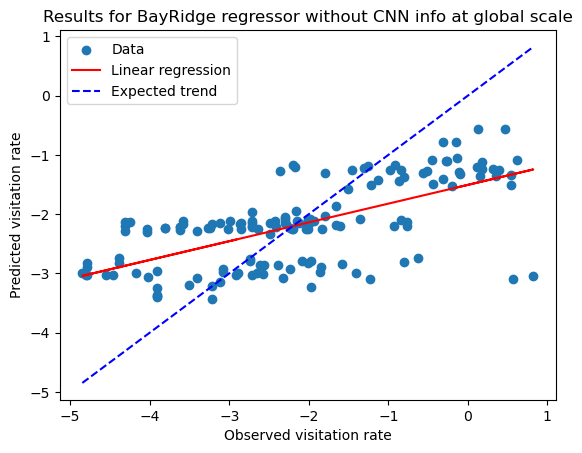

In [26]:
import matplotlib.pyplot as plt
import numpy as np

y_true = y_test.to_numpy()
y_true_array = y_true.flatten()
# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_NO_CNN, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_NO_CNN, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for BayRidge regressor without CNN info at global scale')

# show legend
plt.legend()

# show plot
plt.show()

bio02: VIP = 10.693305261227938
bio01: VIP = 10.247257957723725
elevation: VIP = 9.059483610344524
management_y: VIP = 8.866089753059512
x0_4.0: VIP = 7.811767706216657
x0_8.0: VIP = 7.238434861033114
x0_7.0: VIP = 5.643140699231828
x0_2.0: VIP = 5.233843488505268
gHM: VIP = 5.21694345652993
moss: VIP = 5.087220601970013
ec: VIP = 3.3852935138876483
bio05: VIP = 3.352149187928019
bio08: VIP = 3.2466914873196644
shrub: VIP = 3.0794163304384012
soil_den_b10: VIP = 2.7863158996839394
x0_10.0: VIP = 2.68723596314538
x0_12.0: VIP = 2.3472454357959704
x0_5.0: VIP = 1.9662856867209186
es: VIP = 1.84949159819454
bio14: VIP = 1.1657482362635085
x0_1.0: VIP = 0.6436651034613913
pdsi: VIP = 0.5475761729234212


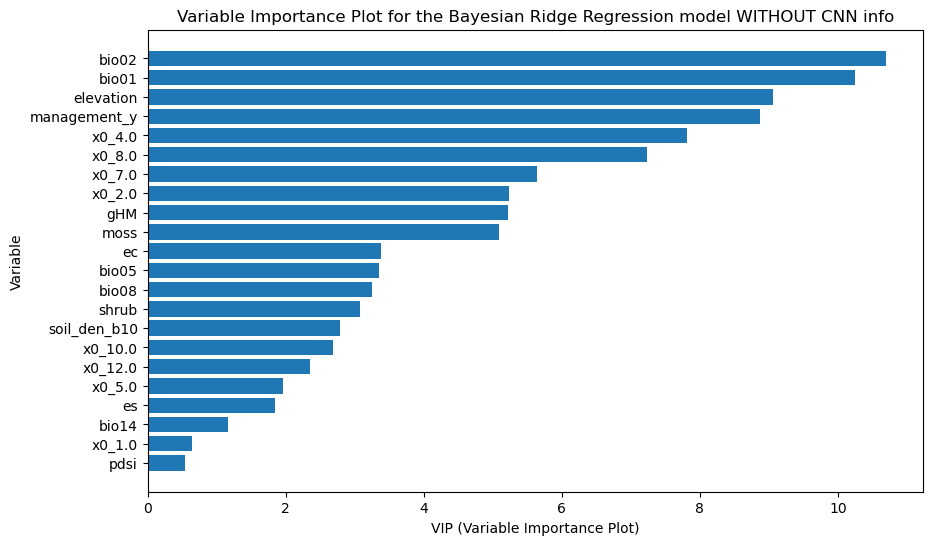

In [27]:
# Get coef. from the best model estimated
coeficients_NO_CNN = best_model_NO_CNN.coef_

# Get variance from the estimated coeficients
variance_coefs_NO_CNN = np.var(coeficients_NO_CNN)

# Estimate VIP for each variable
VIP_NO_CNN = np.abs(coeficients_NO_CNN) / variance_coefs_NO_CNN

# Sort VIP
sorted_indices_NO_CNN = np.argsort(VIP_NO_CNN)[::-1]  # Sort from larger to smaller VIP
sorted_VIP_NO_CNN = VIP_NO_CNN[sorted_indices_NO_CNN]

# Print VIP
for i, idx in enumerate(sorted_indices_NO_CNN):
    print(f"{X_columns_NO_CNN[idx]}: VIP = {sorted_VIP_NO_CNN[i]}")
    
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices_NO_CNN)), sorted_VIP_NO_CNN, align='center')
plt.yticks(range(len(sorted_indices_NO_CNN)), [X_columns_NO_CNN[i] for i in sorted_indices_NO_CNN])
plt.xlabel('VIP (Variable Importance Plot)')
plt.ylabel('Variable')
plt.title('Variable Importance Plot for the Bayesian Ridge Regression model WITHOUT CNN info')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

In [29]:
y_pred_test_NO_CNN = best_model_NO_CNN.predict(X_test_NO_CNN)
df_ML_test_without_na['BayReg'] = y_pred_test_NO_CNN.flatten()

y_pred_train_NO_CNN = best_model_NO_CNN.predict(X_train_NO_CNN)
df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()

C:\Users\alfon\AppData\Local\Temp\ipykernel_27484\2256980901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_test_without_na['BayReg'] = y_pred_test_NO_CNN.flatten()
C:\Users\alfon\AppData\Local\Temp\ipykernel_27484\2256980901.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML_train_without_na['BayReg'] = y_pred_train_NO_CNN.flatten()


In [52]:
# Probamos a hacer una búsqueda optimizada de parámetros para el neural regressor

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from torch.utils.data import DataLoader, TensorDataset
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

# Definir el modelo de la red neuronal con Batch Normalization y Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear un NeuralNetRegressor
net = NeuralNetRegressor(
    NeuralNetwork,
    module__input_dim=X_train_CNN_Bay_others.shape[1],
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',  # Usa GPU si está disponible
)

# Definir la cuadrícula de hiperparámetros
params = {
    'lr': [0.1],
    'max_epochs': [50],
    'module__hidden_dim1': [32],
    'module__hidden_dim2': [32],
    'module__dropout_rate': [.679,.68,.685,.689,.69,.691],
}

# Convertir los datos a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_CNN_Bay_others, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_CNN_Bay_others, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Realizar la búsqueda de hiperparámetros con GridSearchCV
gs = GridSearchCV(net, params, refit=True, cv=myCViterator, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
gs.fit(X_train_tensor, y_train_tensor)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(gs.best_params_)

# Evaluar el modelo en el conjunto de test
y_pred_test = gs.predict(X_test_tensor)

# Calcular el coeficiente de Spearman
rho = spearmanr(y_test, y_pred_test.flatten())[0]
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.1349        2.7404  0.0149
      2        2.9557        2.3043  0.0170
      3        2.7382        1.9340  0.0200
      4        2.2626        1.8663  0.0170
      5        2.0096        1.5842  0.0170
      6        1.7887        1.6721  0.0190
      7        1.7730        1.6162  0.0180
      8        1.6542        1.6364  0.0200
      9        1.7748        1.7215  0.0180
     10        1.5544        1.6930  0.0200
     11        1.6985        1.6878  0.0220
     12        1.6029        1.6720  0.0180
     13        1.6604        1.6713  0.0220
     14        1.5198        1.6395  0.0180
     15        1.6439        1.7394  0.0190
     16        1.6163        1.6307  0.0220
     17        1.5773        1.6830  0.0190
     18        1.5820        1.6062  0.0170
     19        1.5978        1.6604  0.0180
     20        1

In [54]:
# Guardar el modelo entrenado
torch.save(gs.best_estimator_.module_.state_dict(), '../Data/Calibrated_models/ensemble_model_V0.pth')

In [51]:
import random

# Establecer la semilla para reproducibilidad
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Configurar la semilla
seed = 42
set_seed(seed)

def find_best_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, net, params, myCViterator, rho_threshold):
    rho = 0  # Initialize rho
    best_params = None

    while rho <= rho_threshold:
        # Realizar la búsqueda de hiperparámetros con GridSearchCV
        gs = GridSearchCV(net, params, refit=True, cv=myCViterator, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
        gs.fit(X_train_tensor, y_train_tensor)

        # Evaluar el modelo en el conjunto de test
        y_pred_test = gs.predict(X_test_tensor)

        # Calcular el coeficiente de Spearman
        rho = spearmanr(y_test_tensor, y_pred_test.flatten())[0]
        print(f"Spearman's rho en el conjunto de test: {rho:.4f}")

        if rho > rho_threshold:
            best_params = gs.best_params_
            break

    return best_params, rho

best_params, rho = find_best_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, net, params, myCViterator, coef_spearman_NO_CNN)

print("Mejores hiperparámetros encontrados:")
print(best_params)
print(f"Spearman's rho en el conjunto de test: {rho:.4f}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.4843        1.8601  0.0150
      2        3.2037        1.9921  0.0190
      3        2.9550        1.6990  0.0210
      4        2.4683        2.1616  0.0180
      5        2.0557        2.1349  0.0170
      6        1.9897        1.9785  0.0180
      7        1.8506        1.8620  0.0190
      8        1.8605        1.8281  0.0190
      9        1.7759        1.8303  0.0190
     10        1.7514        1.8575  0.0170
     11        1.6619        1.8552  0.0170
     12        1.6818        1.8444  0.0190
     13        1.7079        1.8229  0.0180
     14        1.6938        1.7771  0.0190
     15        1.6979        1.7661  0.0220
     16        1.6253        1.7622  0.0210
     17        1.6360        1.6854  0.0180
     18        1.5244        1.7012  0.0200
     19        1.6673        1.7475  0.0180
     20        1

      2        2.6526        1.5176  0.0205
      3        2.3659        1.8960  0.0180
      4        2.1249        1.8085  0.0190
      5        1.9974        1.7272  0.0180
      6        1.8983        1.7139  0.0213
      7        1.6498        1.7349  0.0180
      8        1.6657        1.7746  0.0200
      9        1.5583        1.7962  0.0210
     10        1.7223        1.7760  0.0180
     11        1.6671        1.7462  0.0180
     12        1.6290        1.7135  0.0200
     13        1.6833        1.7247  0.0180
     14        1.6614        1.7356  0.0180
     15        1.6449        1.7790  0.0190
     16        1.6054        1.6916  0.0180
     17        1.6390        1.6286  0.0190
     18        1.5165        1.6154  0.0180
     19        1.6156        1.6693  0.0190
     20        1.5502        1.7152  0.0180
     21        1.5892        1.6150  0.0180
     22        1.6781        1.5573  0.0180
     23        1.5905        1.6687  0.0190
     24        1.5856        1.6

      8        1.9258        1.8062  0.0190
      9        1.6682        1.7694  0.0250
     10        1.6722        1.7894  0.0260
     11        1.6457        1.7983  0.0240
     12        1.6166        1.7690  0.0210
     13        1.6272        1.7780  0.0210
     14        1.6140        1.7192  0.0270
     15        1.7006        1.7160  0.0240
     16        1.5904        1.6624  0.0220
     17        1.6138        1.6455  0.0240
     18        1.5614        1.6053  0.0210
     19        1.6598        1.6435  0.0220
     20        1.5714        1.6156  0.0210
     21        1.5808        1.6243  0.0250
     22        1.4422        1.5550  0.0250
     23        1.5309        1.4928  0.0240
     24        1.5492        1.4546  0.0200
     25        1.4907        1.3623  0.0190
     26        1.5510        1.4050  0.0200
     27        1.5289        1.5797  0.0200
     28        1.4325        1.5851  0.0220
     29        1.5378        1.5539  0.0210
     30        1.5250        1.3

KeyboardInterrupt: 

In [58]:
import torch
import torch.nn as nn

# Definir el modelo de la red neuronal con Batch Normalization y Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim1=32, hidden_dim2=32, dropout_rate=0.685):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Crear una instancia del modelo con la misma arquitectura
input_dim = X_train_CNN_Bay_others.shape[1]  # Asegúrate de que este sea el mismo input_dim que usaste al guardar el modelo
ensemble_model = NeuralNetwork(input_dim)

# Cargar los pesos guardados en el modelo
ensemble_model.load_state_dict(torch.load('../Data/Calibrated_models/ensemble_model_V0.pth'))

# Configurar el modelo para evaluación
ensemble_model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=24, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.685, inplace=False)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.685, inplace=False)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [60]:
from scipy.stats import pearsonr, spearmanr
# Hacer predicciones usando el modelo cargado
with torch.no_grad():
    y_pred_test_loaded_model = ensemble_model(X_test_tensor).numpy()

# Convertir y_test a NumPy
y_test_numpy = y_test_tensor.numpy()

# Calcular R^2
r2_ensemble = r2_score(y_test_numpy, y_pred_test_loaded_model)
print(f'R^2 Score: {r2}')

# Calcular MSE
mse_loss_ensemble = mean_squared_error(y_test_numpy, y_pred_test_loaded_model)
print("MSE:", mse_loss_ensemble)

# Calcular RMSE
rmse_loss_ensemble = np.sqrt(mse_loss_ensemble)
print("RMSE:", rmse_loss_ensemble)

# Calcular MAE
mae_loss_ensemble = mean_absolute_error(y_test_numpy, y_pred_test_loaded_model)
print("MAE:", mae_loss_ensemble)

# Aplanar y_test para que tenga una sola dimensión
y_test_flat = y_test_numpy.flatten()

# Calcular Pearson's r
corr_ensemble, p_value_r_ensemble = pearsonr(y_test_flat, y_pred_test_loaded_model.flatten())
print("Pearson's r:", corr_ensemble)
print("p-value (Pearson):", p_value_r_ensemble)

# Calcular Spearman's rho
rho_ensemble, p_value_rho_ensemble = spearmanr(y_test_flat, y_pred_test_loaded_model.flatten())
print("Spearman's rho:", rho_ensemble)
print("p-value (Spearman):", p_value_rho_ensemble)

R^2 Score: 0.17676727795535352
MSE: 1.3858441
RMSE: 1.1772188
MAE: 0.95856446
Pearson's r: 0.6380907992255651
p-value (Pearson): 1.6012376806592865e-18
Spearman's rho: 0.6351994975314353
p-value (Spearman): 2.542851029777713e-18


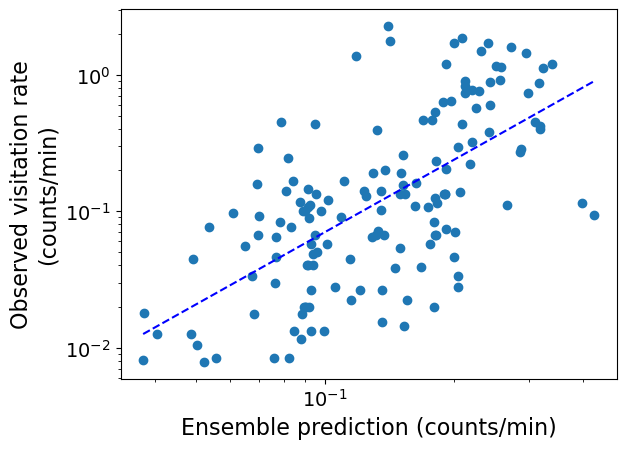

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Convertir y_test a NumPy
y_test_numpy = y_test_tensor.numpy()

# Exponenciar los valores de los puntos
y_test_1d = y_test_numpy.flatten()
y_test_1d_exp = np.exp(y_test_1d)
y_pred_test_exp = np.exp(y_pred_test_loaded_model.flatten())

# Ajustar una línea de regresión con numpy en la escala exponencial
coef = np.polyfit(np.log10(y_pred_test_exp), np.log10(y_test_1d_exp), 1)
poly1d_fn = np.poly1d(coef)

# Crear una gráfica de dispersión con la línea de regresión
plt.scatter(y_pred_test_exp, y_test_1d_exp)
plt.plot(sorted(y_pred_test_exp), 10**poly1d_fn(np.log10(sorted(y_pred_test_exp))), color='blue', linestyle='--')

# Configurar los ejes en escala logarítmica en base diez
plt.xscale('log')
plt.yscale('log')

# Añadir etiquetas a los ejes
plt.xlabel('Ensemble prediction (counts/min)', fontsize=16)
plt.ylabel('Observed visitation rate\n(counts/min)', fontsize=16)

# Ajustar el tamaño de los valores de los ejes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Guardar la imagen
plt.savefig('../Figures/ensemble_scatter_plot_log_scale.png', dpi=300, bbox_inches='tight')

# Mostrar la gráfica
plt.show()

In [55]:
# Guardar los mejores hiperparámetros y el modelo entrenado
best_model = gs.best_estimator_.module_
# torch.save(best_model.state_dict(), 'best_model.pth') #Comentado por seguridad

In [316]:
#Mejores hiperparámetros encontrados (ReLu, grid completa, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.7, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6270
# Muy cerca del BayRidgdge (0.63)

#Mejores hiperparámetros encontrados (SeLu, grid completa, cv=3):
#{'lr': 0.01, 'max_epochs': 50, 'module__dropout_rate': 0.9, 'module__hidden_dim1': 128, 'module__hidden_dim2': 64}
#Spearman's rho en el conjunto de test: 0.5036

#Mejores hiperparámetros encontrados(SeLu, grid parcial, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.7, 'module__hidden_dim1': 16, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.5219

#Mejores hiperparámetros encontrados(ReLu, grid parcial, cv=3):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.69, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6320

#Mejores hiperparámetros encontrados(ReLu, grid parcial, cv=my_cviterator):
#{'lr': 0.1, 'max_epochs': 50, 'module__dropout_rate': 0.68, 'module__hidden_dim1': 32, 'module__hidden_dim2': 32}
#Spearman's rho en el conjunto de test: 0.6464